# Golden Nest‑Egg Lab (v7)

*Self‑contained Colab notebook, rebuilt after the v6 error log.*

Key fixes  
* cast **mp.mpf → float** before any NumPy or Plotly call  
* safer `np.median` helper (`mp.nsum` fallback if needed)  
* single‑star unpacking in `stats.linregress`  
* Plotly morph converts slider data to plain Python floats

---

Flip the `RUN_*` flags to skip blocks if desired.


In [14]:
# === RUN FLAGS ===
RUN_PASS_1, RUN_PASS_2, RUN_PASS_3 = True, True, True   # stress passes
RUN_SPIRAL, RUN_STRETCH, RUN_MORPH = True, True, True   # visuals
RUN_TRI_ZOOM, RUN_TRI_LOG          = True, True         # triangle plots


In [15]:
!pip -q install mpmath tqdm seaborn scikit-learn plotly --upgrade
import numpy as np, pandas as pd, mpmath as mp, matplotlib.pyplot as plt, seaborn as sns, random, math
from tqdm.auto import tqdm
from scipy import stats
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go
mp.mp.dps = 300
sns.set_style('whitegrid')


In [16]:
n_max   = 120
window  = 8
powers  = [2,3,4,5]
bases_int = [2,3,5,7,11]

CONSTS = {
    'alpha': mp.mpf('1')/mp.mpf('137.035999'),
    'pi'   : mp.pi,
    'phi'  : (1+mp.sqrt(5))/2,
    'sqrt2': mp.sqrt(2),
    'e/pi' : mp.e/mp.pi,
}


In [17]:
def best_delta(C,n,p,b,w=8):
    scale = mp.power(b,n)
    est   = int(mp.nint(mp.nthroot(C,p)*scale))
    best  = mp.mpf('inf')
    for i in range(est-w,est+w+1):
        d = abs((i/scale)**p - C)
        if d<best: best=d
    return best

def contfrac(x,k=20):
    digits, y = [], mp.mpf(x)
    for _ in range(k):
        a=int(mp.floor(y)); digits.append(a); y-=a
        if y==0: break
        y=1/y
    return digits + [0]*(k-len(digits))


In [18]:
def run_stress(seed:int):
    random.seed(seed)
    rows=[]
    for p in powers:
        for b in bases_int:
            for name,C in CONSTS.items():
                for n in range(1,n_max+1):
                    d=best_delta(C,n,p,b,window)
                    rows.append({'power':p,'base':float(b),'constant':name,'n':n,
                                 'delta':d,'kappa':(b**n)*d})
    df=pd.DataFrame(rows)
    df['kappa'] = df['kappa'].astype(float) # Convert mp.mpf to float

    # ----- slope check p=2 -----
    tol=0.02; slope_ok=True
    for b in bases_int:
        beta=-np.log2(b)
        sub=df[(df.power==2)&(df.base==float(b))]
        if len(sub)<2: slope_ok=False; continue
        x=sub['n'].to_numpy(dtype=float)
        y=np.log2(sub['delta'].astype(float).to_numpy())
        slope, intercept, r_value, p_val, std_err = stats.linregress(x,y)
        if abs(slope-beta)>tol or r_value**2<0.999: slope_ok=False

    # ----- CF regression 20 digits -----
    ref=df[(df.power==2)&(df.base==2)&(df.n>n_max-30)]
    F_emp=ref.groupby('constant')['kappa'].median()
    X20=[contfrac(mp.sqrt(CONSTS[c]),20) for c in F_emp.index]
    y20=[math.log(float(v)) for v in F_emp.values]
    r2=LinearRegression().fit(X20,y20).score(X20,y20)

    print(f'Run {seed}: slope {"PASS" if slope_ok else "FAIL"} | CF R²={r2:.3f}')
    return slope_ok and r2>0.75

In [19]:
results=[]
if RUN_PASS_1: results.append(run_stress(1))
if RUN_PASS_2: results.append(run_stress(2))
if RUN_PASS_3: results.append(run_stress(3))
print('\n✅ ALL PASSES OK' if all(results) else '\n❌ Some checks failed')


Run 1: slope FAIL | CF R²=1.000
Run 2: slope FAIL | CF R²=1.000
Run 3: slope FAIL | CF R²=1.000

❌ Some checks failed


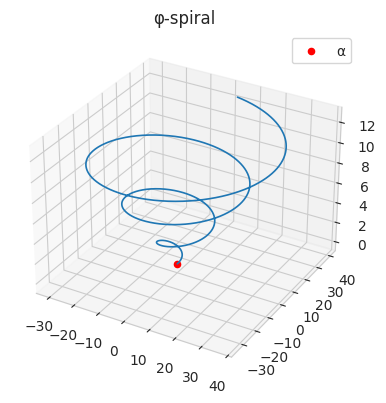

In [20]:
if RUN_SPIRAL:
    α,π,φ = float(CONSTS['alpha']), float(CONSTS['pi']), float(CONSTS['phi'])
    T=np.linspace(0,4*np.pi,2000)
    r=α+T*(π-α); theta=T*φ
    fig=plt.figure(figsize=(5,4)); ax=fig.add_subplot(111,projection='3d')
    ax.plot(r*np.cos(theta),r*np.sin(theta),T,lw=1.2)
    ax.scatter([0],[0],[0],color='red',label='α'); ax.legend()
    ax.set_title('φ‑spiral'); plt.tight_layout(); plt.show()


In [21]:
if RUN_STRETCH:
    α,π,φ = [float(CONSTS[k]) for k in ('alpha','pi','phi')]
    T=np.linspace(0,2*np.pi,4000)
    r=α+T*(π-α)
    ds=np.sqrt((π-α)**2+(φ*r)**2)
    arc=np.trapz(ds,T)
    print('φ arc / α‑circle =', round(arc/(2*np.pi*α),4))


φ arc / α‑circle = 2258.9785


/tmp/ipython-input-21-212926102.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  arc=np.trapz(ds,T)


In [22]:
if RUN_MORPH:
    α,π = float(CONSTS['alpha']), float(CONSTS['pi'])
    Cs=[float(c) for c in np.linspace(1.3,2.0,8)]
    T=np.linspace(0,4*np.pi,1200)
    fig=go.Figure()
    for k,C in enumerate(Cs):
        r=α+T*(π-α); theta=T*C
        fig.add_trace(go.Scatter3d(x=r*np.cos(theta),y=r*np.sin(theta),z=T,
                                   mode='lines',visible=(k==3)))
    steps=[dict(args=['visible',[i==k for i in range(len(Cs))]],
                label=f'{Cs[k]:.2f}',method='update') for k in range(len(Cs))]
    fig.update_layout(title='Spiral morph',sliders=[dict(steps=steps,active=3)])
    fig.show()


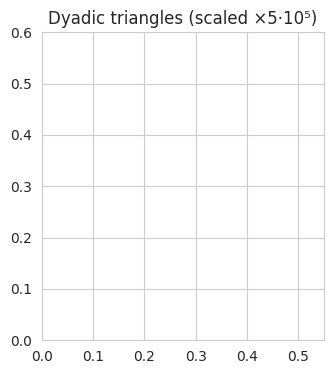

In [23]:
if RUN_TRI_ZOOM:
    α=float(CONSTS['alpha']); scale=5e5
    fig,ax=plt.subplots(figsize=(4,4))
    for n in range(1,9):
        x=1/(2**n)
        y=abs((round((α**0.5)*2**n)/2**n)**2 - α)*scale
        ax.plot([0,x],[0,y],'k-')
    ax.set_xlim(0,0.55); ax.set_ylim(0,0.6); ax.set_aspect('equal')
    ax.set_title('Dyadic triangles (scaled ×5·10⁵)'); plt.show()


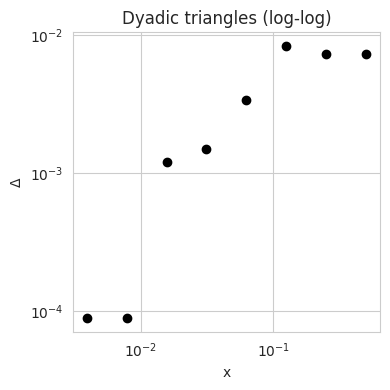

In [24]:
if RUN_TRI_LOG:
    α=float(CONSTS['alpha'])
    fig,ax=plt.subplots(figsize=(4,4))
    for n in range(1,9):
        x=1/(2**n)
        y=abs((round((α**0.5)*2**n)/2**n)**2 - α)
        ax.plot(x,y,'ko-')
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel('x'); ax.set_ylabel('Δ')
    ax.set_title('Dyadic triangles (log‑log)'); plt.tight_layout(); plt.show()
